In [1]:
from gurobipy import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import time
import re
import os
colores_rutas = ['green', 'orange', 'purple', 'brown', 'pink', 'blue', 'black', 'red', 'yellow', 'grey']

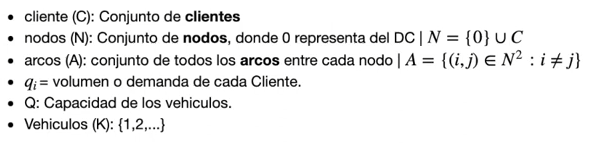

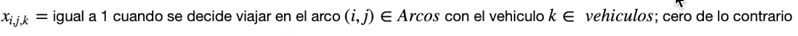

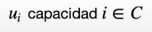

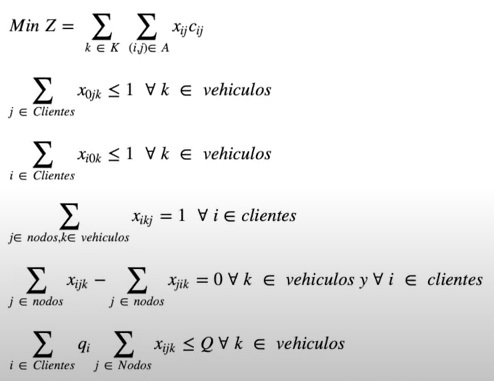

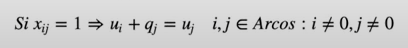

In [61]:
with open ("INSTANCES/A/A-n45-k7.vrp") as archivo:
    nomb = ""
    dim = 0
    veh = 0
    cap = 0
    autos = []
    x_coord = []
    y_coord = []
    dema = {}  
    coordenadas = False  
    demandas = False  
    
    for linea in archivo:

        if linea.startswith("NAME"):
            nomb = (linea.strip().split(":")[1]).strip() + ".vrp"

        if linea.startswith("COMMENT"):
            resultado = re.search(r'of trucks:\s*(\d+)', linea, re.IGNORECASE)
            if resultado:
                veh = int(resultado.group(1))

        if linea.startswith("VEHIC"):
            veh = int(linea.strip().split(":")[1])
                
        if linea.startswith("DIMEN"):
            dim = int(linea.strip().split(":")[1])

        elif linea.startswith("CAPAC"):
            cap = int(linea.strip().split(":")[1])

        elif linea.startswith("NODE_COORD_SECTION"):
            coordenadas = True
            continue

        elif linea.startswith("DEMAND_SECTION"):
            coordenadas = False
            demandas = True
            continue

        elif linea.startswith("DEPOT_SECTION"):
            demandas = False

        elif coordenadas:
            coords = linea.split()
            if len(coords) >= 3:  
                x_coord.append(float(coords[1]))
                y_coord.append(float(coords[2]))

        elif demandas:
            demands = linea.split()
            if len(demands) >= 2:
                nodo, dem = int(demands[0]), int(demands[1])
                dema[nodo - 1] = dem  

for i in range(veh):
    autos.append(i+1)
        
cap_x_veh = {i: cap for i in range(1, veh + 1)}

In [62]:
# Nodos (arreglar la cantidad de clientes)
n = dim
# Conjunto de clientes
clientes = [i for i in range(n) if i != 0]
# Conjuntos de nodos 
nodos = [0] + clientes
# Arco entre todos los nodos
arcos = [(i,j) for i in nodos for j in nodos if i != j]

# Demanda (cambiar random a lista de las demandas)
# Semilla para que los datos sean siempre los mismos
np.random.seed(0)

# Definicion para que los pedidos sean siempre con un valor entre 10 y 15
demanda = dema
q = {n:demanda[i] for i,n in enumerate(clientes)}

# Nodo 0 = Capacidad 0
q[0] = 0

#Vehiculos
vehiculos = [1, 2,3,4,5,6,7]

#Capacidad de Cada Vehiculo
Q = {1: 100 , 2:100, 3:100, 4:100, 5:100, 6:100,7:100}

# Coordenadas (Cambiar random por lista de ubicacion de clientes)

X = x_coord
Y = y_coord

In [63]:
# Distancia
distancia = {(i,j): np.hypot(X[i] - X[j], Y[i] - Y[j]) for i in nodos for j in nodos if i != j}
distancia[3,0]

69.42621983083913

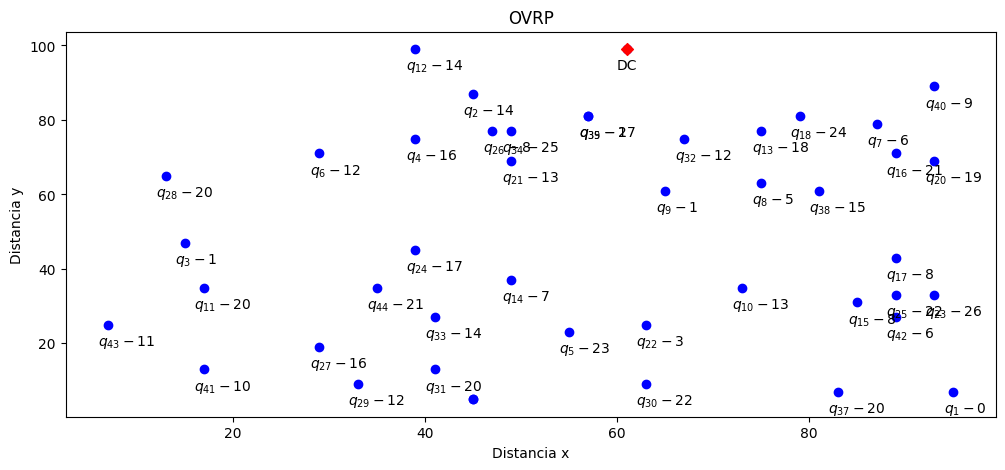

In [64]:
#Grafico
plt.figure(figsize = (12,5))
plt.scatter(X,Y, color = 'blue')

#DC
plt.scatter(X[0], Y[0], color = 'red', marker = 'D')
plt.annotate("DC", (X[0]-1, Y[0]-5.5))
#Clientes y demanda
for i in clientes:
    plt.annotate('$q_{%d} - %d$'%(i,q[i]), (X[i]-1, Y[i]-5.5))

plt.xlabel("Distancia x")
plt.ylabel("Distancia y")
plt.title("OVRP")

plt.show()

In [65]:
# Arcos para el modelo
arcos_var = [(i,j,k) for i in nodos for j in nodos for k in vehiculos if i != j]

In [71]:
# Modelo
model = Model('OVRP')

# Variables de Decision
x = model.addVars(arcos_var, vtype = GRB.BINARY, name = 'x')
u = model.addVars(clientes, ub = Q, vtype = GRB.CONTINUOUS, name = 'u')

# Funcion Objetivo
model.setObjective(quicksum(distancia[i,j]*x[i,j,k] for i,j,k in arcos_var), GRB.MINIMIZE)

#Restriccion Entrada y Salida de DC (Base) (Arreglar para que solo sea Salida sin retorno a base)
model.addConstrs(quicksum(x[0,j,k] for j  in clientes) <= 1 for k in vehiculos)
model.addConstrs(quicksum(x[i,0,k] for i in clientes) <= 1 for k in vehiculos)

#1 Vehiculo por nodo
model.addConstrs(quicksum(x[i,j,k] for j in nodos for k in vehiculos if i !=j) == 1 for i in clientes)

#Conservacion de flujo
model.addConstrs(quicksum(x[i,j,k] for j in nodos if i != j) - quicksum(x[j,i,k] for j in nodos if i != j) == 0 for i in nodos for k in vehiculos)
                 
#Restricicon Sub Tur
model.addConstrs((x[i,j,k] == 1 ) >> (u[i] + q[j] == u[j]) for i,j,k in arcos_var if j != 0 and i != 0)

#Restriccion de Capacidad
model.addConstrs(quicksum(q[i] * quicksum(x[i,j,k] for j in nodos if i != j) for i in clientes) <= Q[k] for k in vehiculos)

#Limitacion de tiempo
model.Params.timeLimit = 3600
#model.Params.MIGap = 0.1

model.optimize()

#definir funcion que elimine el arco final en el ultimo costo de vuelta a base

Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-5250U CPU @ 1.60GHz
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads

Optimize a model with 380 rows, 13904 columns and 55132 nonzeros
Model fingerprint: 0x5b3667f1
Model has 13244 general constraints
Variable types: 44 continuous, 13860 integer (13860 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [2e+00, 1e+02]
  Bounds range     [1e+00, 1e+02]
  RHS range        [1e+00, 1e+02]
  GenCon rhs range [1e+00, 3e+01]
  GenCon coe range [1e+00, 1e+00]
Presolve added 13538 rows and 12950 columns
Presolve time: 0.47s
Presolved: 13918 rows, 26854 columns, 101675 nonzeros
Presolved model has 12950 SOS constraint(s)
Variable types: 12994 continuous, 13860 integer (13860 binary)
Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Use crossover to c

In [72]:
#Imprimir los Valores
print("Funcion Objetivo: ", str(round(model.ObjVal,2)))
for v in model.getVars(): 
    if v.x >0.9:
        print(str(v.VarName)+"="+str(v.x))

Funcion Objetivo:  1205.86
x[0,5,7]=1.0
x[0,6,1]=1.0
x[0,12,5]=1.0
x[0,17,4]=1.0
x[0,19,6]=1.0
x[0,24,3]=1.0
x[0,40,2]=1.0
x[1,42,7]=1.0
x[2,4,5]=1.0
x[3,11,1]=1.0
x[4,26,5]=1.0
x[5,37,7]=1.0
x[6,28,1]=1.0
x[7,18,2]=1.0
x[8,32,4]=1.0
x[9,0,3]=1.0
x[10,38,7]=1.0
x[11,14,1]=1.0
x[12,2,5]=1.0
x[13,0,7]=1.0
x[14,21,1]=1.0
x[15,25,4]=1.0
x[16,7,2]=1.0
x[17,15,4]=1.0
x[18,0,2]=1.0
x[19,36,6]=1.0
x[20,16,2]=1.0
x[21,34,1]=1.0
x[22,9,3]=1.0
x[23,8,4]=1.0
x[24,44,3]=1.0
x[25,23,4]=1.0
x[26,35,5]=1.0
x[27,41,6]=1.0
x[28,3,1]=1.0
x[29,27,6]=1.0
x[30,22,3]=1.0
x[31,30,3]=1.0
x[32,0,4]=1.0
x[33,31,3]=1.0
x[34,0,1]=1.0
x[35,39,5]=1.0
x[36,29,6]=1.0
x[37,1,7]=1.0
x[38,13,7]=1.0
x[39,0,5]=1.0
x[40,20,2]=1.0
x[41,43,6]=1.0
x[42,10,7]=1.0
x[43,0,6]=1.0
x[44,33,3]=1.0
u[1]=20.0
u[2]=13.999999999999972
u[3]=21.0
u[4]=29.99999999999997
u[7]=46.0
u[8]=69.00000000000028
u[9]=80.99999999999997
u[10]=39.0
u[11]=41.0
u[13]=72.0
u[14]=48.0
u[15]=15.999999999999972
u[16]=40.0
u[17]=8.0
u[18]=69.99999999999996
u[1

In [91]:
# Lista de las Rutas
rutas = []
truck = []
K = vehiculos
N = nodos

for k in vehiculos:
    for i in nodos:
        if i != 0 and x[0, i, k].x > 0.9:
            aux = [0, i]
            while i != 0:
                j = i
                for h in nodos:
                    if j != h and x[(j, h, k)].x > 0.9:
                        aux.append(h)
                        i = h
            rutas.append(aux)
            truck.append(k)


# Eliminar el último nodo 0 de cada ruta
for ruta in rutas:
    if ruta[-1] == 0:
        ruta.pop()

print(rutas)
print(truck)


# Calcular la distancia total de todas las rutas
def calcular_distancia_total(rutas, distancia):
    distancia_total = 0
    for ruta in rutas:
        for i in range(len(ruta) - 1):
            distancia_total += distancia[(ruta[i], ruta[i + 1])]
    return distancia_total

# Calcular la distancia total
distancia_total = calcular_distancia_total(rutas, distancia)

print(f"La distancia total de todas las rutas es: {distancia_total}")


[[0, 6, 28, 3, 11, 14, 21, 34], [0, 40, 20, 16, 7, 18], [0, 24, 44, 33, 31, 30, 22, 9], [0, 17, 15, 25, 23, 8, 32], [0, 12, 2, 4, 26, 35, 39], [0, 19, 36, 29, 27, 41, 43], [0, 5, 37, 1, 42, 10, 38, 13]]
[1, 2, 3, 4, 5, 6, 7]
La distancia total de todas las rutas es: 956.2763945221546


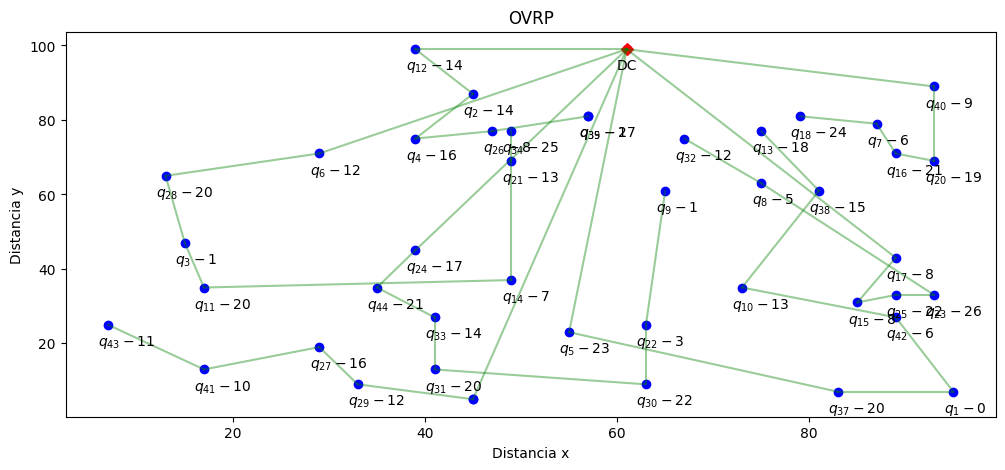

In [92]:
#Grafico con Rutas
plt.figure(figsize = (12,5))
plt.scatter(X,Y, color = 'blue')

#DC
plt.scatter(X[0], Y[0], color = 'red', marker = 'D')
plt.annotate("DC", (X[0]-1, Y[0]-5.5))

#Clientes y demanda
for i in clientes:
    plt.annotate('$q_{%d} - %d$'%(i,q[i]), (X[i]-1, Y[i]-5.5))

#Rutas
for r in range(len(rutas)):
    color_rutas = colores_rutas[r % len(colores_rutas)]
    for n in range(len(rutas[r])-1):
        i = rutas[r][n]
        j = rutas[r][n+1]
        plt.plot([X[i],X[j]],[Y[i],Y[j]],alpha = 0.4, color = 'green')

plt.xlabel("Distancia x")
plt.ylabel("Distancia y")
plt.title("OVRP")

plt.show()